In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
from pyspark.sql.functions import col

In [7]:
loan = spark.read.csv("loan.csv", header=True, inferSchema=True)

In [8]:
loan.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- is_first_loan: integer (nullable = true)
 |-- total_credit_card_limit: integer (nullable = true)
 |-- avg_percentage_credit_card_limit_used_last_year: double (nullable = true)
 |-- saving_amount: integer (nullable = true)
 |-- checking_amount: integer (nullable = true)
 |-- is_employed: integer (nullable = true)
 |-- yearly_salary: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- dependent_number: integer (nullable = true)
 |-- label: integer (nullable = true)



### 대출여부 종속변수는 범주형이므로 분석방법은 분류분석을 이용
+ 로지스틱 회귀, 의사결정나무, 랜덤포레스트, 앙상블

In [9]:
loan.show(5)

+-------+------------+-------------+-----------------------+-----------------------------------------------+-------------+---------------+-----------+-------------+---+----------------+-----+
|loan_id|loan_purpose|is_first_loan|total_credit_card_limit|avg_percentage_credit_card_limit_used_last_year|saving_amount|checking_amount|is_employed|yearly_salary|age|dependent_number|label|
+-------+------------+-------------+-----------------------+-----------------------------------------------+-------------+---------------+-----------+-------------+---+----------------+-----+
|    A_1|    personal|            1|                   7900|                                            0.8|         1103|           6393|          1|        16400| 42|               4|    0|
|    A_2|    personal|            0|                   3300|                                           0.29|         2588|            832|          1|        75500| 56|               1|    0|
|    A_3|    personal|            0|    

### 대출목적이 문자이므로 숫자형으로 변경 필요

### 데이터 전처리

In [10]:
loan2 = loan.toPandas()

In [11]:
loan2.info

<bound method DataFrame.info of        loan_id loan_purpose  is_first_loan  total_credit_card_limit  \
0          A_1     personal              1                     7900   
1          A_2     personal              0                     3300   
2          A_3     personal              0                     7600   
3          A_4     personal              1                     3400   
4          A_5    emergency              0                     2600   
...        ...          ...            ...                      ...   
46746  A_47650    emergency              0                     4800   
46747  A_47651   operations              0                     3800   
46748  A_47652     personal              0                     4800   
46749  A_47653     personal              1                     3200   
46750  A_47654     personal              0                     3800   

       avg_percentage_credit_card_limit_used_last_year  saving_amount  \
0                                         

### 이상치 여부 확인 - 회귀분석 아니므로 큰의미없음

<AxesSubplot:>

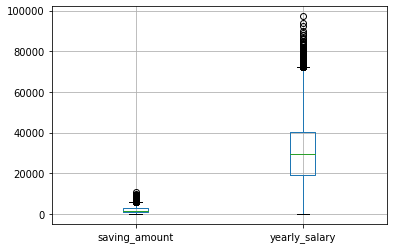

In [13]:
loan2.boxplot(column=['saving_amount','yearly_salary'])

<AxesSubplot:>

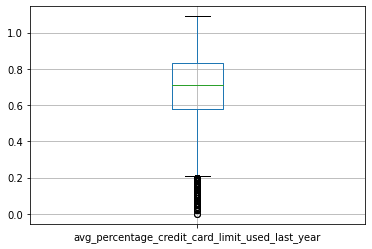

In [14]:
loan2.boxplot(column=['avg_percentage_credit_card_limit_used_last_year'])

### 레이블 인코딩 - one, two, three 등의 데이터를 레이블 인코딩하면?
+ 0 : one, 1 : three, 2 : two

### 원핫인코딩 : 레이블인코딩의 단점 보완
+ one, two, three등의 데이터를 원핫 인코딩하면?
### 1   0   0     : one
### 0   1   0     : two
### 0   0   1     : three
### 최종적으로 만들어진 코드 : 100, 010, 001

### 범주형 변수를 수치형으로 변경

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

### 문자형 변수의 값을 숫자형으로 변환하기 위해 레이블인코딩 수행
+ StringIndexer(입력컬럼, 대상컬럼).fit(데이터프레임)

In [22]:
lp_idx = StringIndexer(inputCol='loan_purpose', outputCol='lp_idx').fit(loan)

#### 레이블 인코딩 결과를 이용해서 대출목적 컬럼의 값을 숫자형으로 변경

In [25]:
loan = lp_idx.transform(loan)

In [26]:
loan.select('loan_purpose', 'lp_idx').show(5)

+------------+------+
|loan_purpose|lp_idx|
+------------+------+
|    personal|   2.0|
|    personal|   2.0|
|    personal|   2.0|
|    personal|   2.0|
|   emergency|   3.0|
+------------+------+
only showing top 5 rows



### 분류분석을 위해 원핫인코딩으로 변환

In [35]:
lp_ohe = OneHotEncoder(inputCol='lp_idx', outputCol='lp_ohe')

In [36]:
loan = lp_ohe.transform(loan)

In [37]:
loan.select('loan_purpose', 'lp_idx', 'lp_ohe').show(5)

+------------+------+-------------+
|loan_purpose|lp_idx|       lp_ohe|
+------------+------+-------------+
|    personal|   2.0|(4,[2],[1.0])|
|    personal|   2.0|(4,[2],[1.0])|
|    personal|   2.0|(4,[2],[1.0])|
|    personal|   2.0|(4,[2],[1.0])|
|   emergency|   3.0|(4,[3],[1.0])|
+------------+------+-------------+
only showing top 5 rows



### 독립변수와 종속변수를 하나로 묶음

In [40]:
vdf = VectorAssembler(inputCols=['lp_ohe', 'is_first_loan', 'total_credit_card_limit', 'avg_percentage_credit_card_limit_used_last_year', 'saving_amount', 'checking_amount', 'is_employed', 'yearly_salary', 'age', 'dependent_number'], outputCol='features')

### vector assembler 객체를 이용해서 벡터화 수행

In [41]:
loans = vdf.transform(loan)

In [43]:
loans.select('features', 'label').show(5, False)

+--------------------------------------------------------------------+-----+
|features                                                            |label|
+--------------------------------------------------------------------+-----+
|[0.0,0.0,1.0,0.0,1.0,7900.0,0.8,1103.0,6393.0,1.0,16400.0,42.0,4.0] |0    |
|[0.0,0.0,1.0,0.0,0.0,3300.0,0.29,2588.0,832.0,1.0,75500.0,56.0,1.0] |0    |
|[0.0,0.0,1.0,0.0,0.0,7600.0,0.9,1651.0,8868.0,1.0,59000.0,46.0,1.0] |0    |
|[0.0,0.0,1.0,0.0,1.0,3400.0,0.38,1269.0,6863.0,1.0,26000.0,55.0,8.0]|0    |
|[0.0,0.0,0.0,1.0,0.0,2600.0,0.89,1310.0,3423.0,1.0,9700.0,41.0,4.0] |1    |
+--------------------------------------------------------------------+-----+
only showing top 5 rows



### 분석을 위해 독립변수와 종속변수를 추출하여 새로운 변수 생성

In [44]:
model_df = loans.select('features', 'label')

In [45]:
model_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,1.0,0.0,...|    0|
|[0.0,0.0,1.0,0.0,...|    0|
|[0.0,0.0,1.0,0.0,...|    0|
|[0.0,0.0,1.0,0.0,...|    0|
|[0.0,0.0,0.0,1.0,...|    1|
+--------------------+-----+
only showing top 5 rows



### train. test로 분리

In [46]:
train, test= model_df.randomSplit([0.75, 0.25])

### 모델 훈련

In [47]:
from pyspark.ml.classification import LogisticRegression

In [48]:
lg = LogisticRegression().fit(train)

21/10/11 07:45:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/11 07:45:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/11 07:45:14 WARN BlockManager: Asked to remove block broadcast_27_piece0, which does not exist


In [50]:
trainmodel= lg.summary

In [51]:
trainmodel.accuracy    #정확도

0.8946426033821231

In [54]:
trainmodel.precisionByLabel    # 정밀도

[0.9242104337116214, 0.8406553690466629]

In [53]:
trainmodel.recallByLabel    # 재현율

[0.9137203739943466, 0.8586546349466776]

In [55]:
trainmodel.areaUnderROC    # AUC 값

0.9591740651969674

### 모델 예측

In [57]:
pred = lg.transform(test)

In [58]:
pred.show(10, False)  #예측결과 확인

[Stage 80:>                                                         (0 + 1) / 1]

+---------------------------------------------------------------+-----+----------------------------------------+------------------------------------------+----------+
|features                                                       |label|rawPrediction                           |probability                               |prediction|
+---------------------------------------------------------------+-----+----------------------------------------+------------------------------------------+----------+
|(13,[0,4,5,6,7,8,11],[1.0,1.0,2700.0,0.49,1802.0,526.0,66.0])  |1    |[-2.7686483784735962,2.7686483784735962]|[0.05904205953886716,0.9409579404611329]  |1.0       |
|(13,[0,4,5,6,7,8,11],[1.0,1.0,4500.0,0.98,1145.0,685.0,47.0])  |1    |[-3.902842451516627,3.902842451516627]  |[0.019785104900077198,0.9802148950999229] |1.0       |
|(13,[0,5,6,7,8,11],[1.0,4500.0,0.24,2553.0,6557.0,38.0])       |0    |[5.170270575476525,-5.170270575476525]  |[0.9943490834113425,0.00565091658865739]  |0.0       

In [59]:
pred = lg.evaluate(test)

In [60]:
pred.accuracy

0.8927892097527235

In [61]:
pred.precisionByLabel

[0.9199361617236335, 0.8423523597726711]

In [64]:
pred.recallByLabel 

[0.9155526141628061, 0.849912739965096]

In [63]:
pred.areaUnderROC  

0.9582241819773916

### 오차행렬 confusion matrix

In [69]:
from sklearn.metrics import confusion_matrix

In [71]:
pred = lg.transform(test)

In [72]:
y_true = pred.select(['label']).collect()

In [74]:
y_pred = pred.select(['prediction']).collect()

In [75]:
confusion_matrix(y_true, y_pred)

array([[6917,  638],
       [ 602, 3409]])